<a href="https://colab.research.google.com/github/ojaashampiholi/Techpoint-Covid19/blob/dev/Scoring_%26_Maps_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

     |████████████████████████████████| 962kB 4.5MB/s 
     |████████████████████████████████| 14.7MB 299kB/s 
     |████████████████████████████████| 10.9MB 39.3MB/s 


In [2]:
pip install us

     |████████████████████████████████| 133kB 5.5MB/s 
  Created wheel for us: filename=us-2.0.2-cp36-none-any.whl size=11927 sha256=1082374f1284e67313aac1dd969d105c75fbfe863c8c65a3dd3be7f19e5d7bab
  Stored in directory: /root/.cache/pip/wheels/e2/16/45/6453383ffa495670f0f6b80a3e697a9771d98cfbaf8b451e73
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp36-cp36m-linux_x86_64.whl size=74752 sha256=8b06ef0d3822b0b5047ee5bc842279fcf88954e679878f8c89245ccdcd8c171a
  Stored in directory: /root/.cache/pip/wheels/9c/6f/33/92bb9a4b4562a60ba6a80cedbab8907e48bc7a8b1f369ea0ae
Successfully built us jellyfish


In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import us
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

            date   county  new test
0     2020-02-29    adams         0
1     2020-03-02    adams         0
2     2020-03-03    adams         0
3     2020-03-04    adams         0
4     2020-03-05    adams         1
...          ...      ...       ...
11955 2020-07-04  whitley         9
11956 2020-07-05  whitley         6
11957 2020-07-06  whitley        18
11958 2020-07-07  whitley         0
11959 2020-07-08  whitley         0

[11960 rows x 3 columns]


In [25]:
def getData():
    url = 'https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv?raw=true'
    df = pd.read_csv(url, parse_dates=[0])
    df = df[df['state']=='Indiana']
    df['county'] = df['county'].str.lower()
    df = df[['date', 'county', 'cases', 'deaths']]

    url2 = 'https://hub.mph.in.gov/datastore/dump/afaa225d-ac4e-4e80-9190-f6800c366b58?bom=True'  
    X = pd.read_csv(url2, parse_dates=[2])
    featureColumns = ['date', 'county_name', 'm1e_covid_tests']
    X = X[featureColumns]
    X['county_name'] = X['county_name'].str.lower()
    X = X.rename(columns={"date": "date", "county_name": "county", "m1e_covid_tests":"new test"})
    # print(X)

    combinedData = df.merge(X, on=['date', 'county'])

    counties = combinedData['county'].unique()
    dfNew = combinedData[combinedData['county']==counties[0]]
    dfNew = dfNew[-1:]
    #print(dfNew)
    for county in counties[1:]:
        df1 = combinedData[combinedData['county']==county]
        df1 = df1[-1:]
        dfNew = dfNew.append(df1, ignore_index=True)
    dfNew['cases'] = dfNew['cases']/dfNew['cases'].max()
    dfNew['deaths'] = dfNew['deaths']/dfNew['deaths'].max()
    dfNew['new test'] = dfNew['new test']/dfNew['new test'].max()
    return dfNew

def getMapData():
    fp = "/content/drive/My Drive/Techpoint/tl_2010_18_county10.shp"
    map_df = gpd.read_file(fp)
    map_df['NAME10'] = map_df['NAME10'].str.lower()
    return map_df

def getMergedData():
    dfNew = getData()
    df_map = getMapData()
    merged = df_map.merge(dfNew, how='left', left_on="NAME10", right_on="county")
    merged = merged[['county', 'geometry', 'cases', 'deaths', 'new test']]
    merged['county'] = merged['county'].str.upper()
    return merged

In [58]:
def IndianaMap(merged, vars, mapColors = 'YlOrRd'):
    my_path = '/content/drive/My Drive/Techpoint/Indiana_Maps/'
    vmin, vmax = 0, 1
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(35, 14))
    merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    # merged['casesText'] = merged['county'] + str(merged['cases'])

    ax1.axis('off')
    ax1.set_title(str(vars[0]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
    merged.plot(column=vars[0], cmap=mapColors, linewidth=0.8, ax=ax1, edgecolor='0.5')
    for idx, row in merged.iterrows():
        ax1.annotate(s=row['county'], xy=row['coords'],horizontalalignment='center', rotation=30)


    ax2.axis('off')
    ax2.set_title(str(vars[1]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
    merged.plot(column=vars[1], cmap=mapColors, linewidth=0.8, ax=ax2, edgecolor='0.5')
    for idx, row in merged.iterrows():
        ax2.annotate(s=row['county'], xy=row['coords'],horizontalalignment='center', rotation=30)

    ax3.axis('off')
    ax3.set_title(str(vars[2]) + ' per county', fontdict={'fontsize': '25', 'fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap=mapColors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    merged.plot(column=vars[2], cmap=mapColors, linewidth=0.8, ax=ax3, edgecolor='0.5')
    for idx, row in merged.iterrows():
        ax3.annotate(s=row['county'], xy=row['coords'],horizontalalignment='center', rotation=30)
    fig.colorbar(sm)
    plt.savefig(my_path + 'Indiana_Map.png')
    # print(merged)
    plt.show()

In [59]:
merged = getMergedData()
vars = ['cases', 'deaths', 'new test']

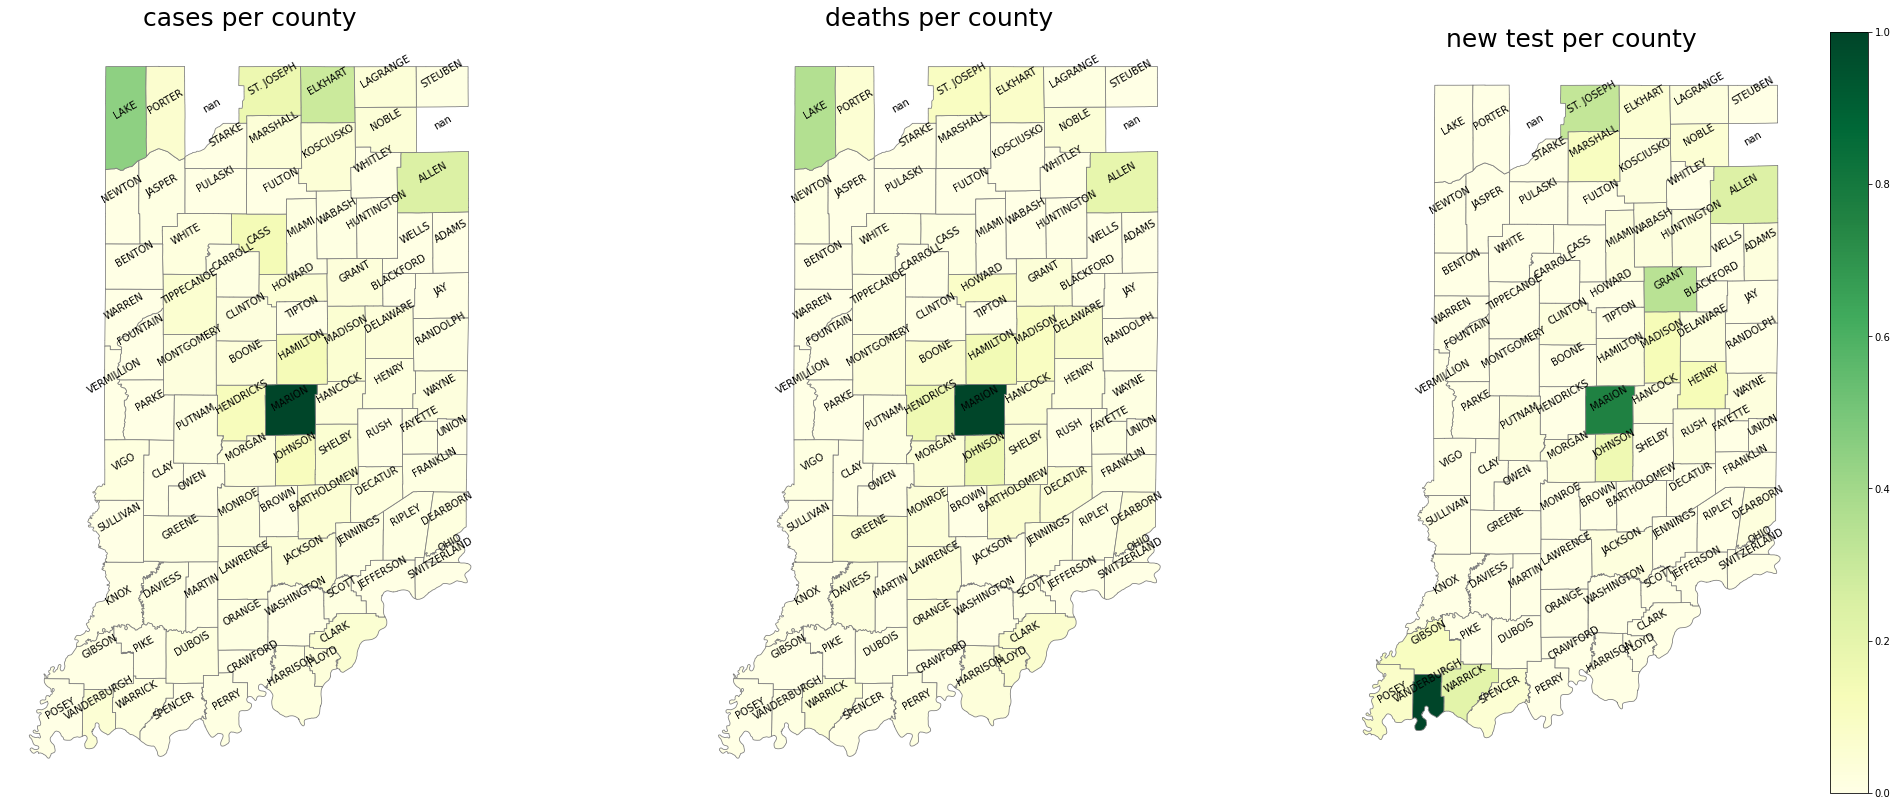

In [60]:
IndianaMap(merged, vars, 'YlGn')